<a href="https://colab.research.google.com/github/Ravhihz/Sentinanalytica/blob/main/Prepro_%2B_LDA_Modeling_%2B_Fuzzy_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pandas numpy emoji clean-text[gpl] langdetect Sastrawi unidecode
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
# === 1) Import & Konfigurasi ===
import pandas as pd, numpy as np, re, math, emoji, unicodedata
from cleantext import clean
from langdetect import detect
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from unidecode import unidecode

# --- sesuaikan nama kolom bila perlu ---
CSV_PATH   = "/content/mbg2_text_merged.csv"   # upload ke /content
TEXT_COL   = "full_text"
LIKE_COL   = "like_count"          # opsional
RT_COL     = "retweet_count"       # opsional
REPLY_COL  = "reply_count"         # opsional
QUOTED_COL = "quote_count"         # opsional
USER_FOLLOWER_COL = "user_followers"  # opsional
DATE_COL   = "created_at"          # opsional
LANG_COL   = None                  # jika belum ada kolom bahasa


In [ ]:
# === 2) Load & Audit ===
df = pd.read_csv(CSV_PATH, encoding="utf-8", low_memory=False)
print("shape awal:", df.shape)
df = df[~df[TEXT_COL].isna()].copy()
df["text_raw"] = df[TEXT_COL].astype(str)
print(df.columns.tolist()[:25])


shape awal: (9792, 15)
['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username', 'text_raw']


In [ ]:
# === 3) Hilangkan duplikat berbasis normalisasi sederhana ===
def _dupe_norm(s):
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

df["_dupe_key"] = df["text_raw"].map(_dupe_norm)
bef = len(df)
df = df.drop_duplicates(subset=["_dupe_key"]).drop(columns=["_dupe_key"])
print("hapus duplikat:", bef - len(df))
# (Praktik normal sebelum vektorisasi/topik)


hapus duplikat: 39


In [ ]:
# === 4) Deteksi bahasa & filter ID (opsional tapi dianjurkan) ===
# Pastikan sudah install langdetect:
# !pip install langdetect

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # untuk hasil yang konsisten

def lang_id(s):
    try:
        lang = detect(str(s))
        return lang
    except:
        return "unk"

if LANG_COL is None:
    print("▶️ Melakukan deteksi bahasa otomatis...")
    df["lang_auto"] = df["text_raw"].map(lang_id)
    LANG_COL = "lang_auto"

print("Distribusi bahasa:")
print(df[LANG_COL].value_counts().head())

# Filter hanya bahasa Indonesia atau tidak terdeteksi
df = df[df[LANG_COL].isin(["id", "unk"])].copy()
print("Setelah filter bahasa:", df.shape)


▶️ Melakukan deteksi bahasa otomatis...
Distribusi bahasa:
lang_auto
id    9217
tl     114
de      94
en      76
so      37
Name: count, dtype: int64
Setelah filter bahasa: (9217, 17)


In [ ]:
# === 5) Ekstraksi fitur sosial (disimpan terpisah), lalu hapus dari teks ===
#   - mention_list/mention_count → engagement aktif (outgoing)
#   - hashtag_list/hashtag_count → sinyal topik & aktivisme
#   - url_count → indikasi share/info
#   - emoji_count → isyarat emosi, simpan sebagai fitur (jangan dipakai di teks untuk LDA)
#   (Pendekatan memisahkan social metrics dari teks mengacu pada analisis topik + engagement)

def extract_mentions(s): return re.findall(r"@\w+", s)
def extract_hashtags(s): return re.findall(r"#(\w+)", s, flags=re.UNICODE)
def count_urls(s):       return len(re.findall(r"https?://\S+|www\.\S+", s))
def count_emojis(s):     return sum(1 for ch in s if ch in emoji.EMOJI_DATA)

df["mention_list"] = df["text_raw"].map(extract_mentions)
df["mention_count"] = df["mention_list"].map(len)

df["hashtag_list"] = df["text_raw"].map(extract_hashtags)
df["hashtag_count"] = df["hashtag_list"].map(len)

df["url_count"]   = df["text_raw"].map(count_urls)
df["emoji_count"] = df["text_raw"].map(count_emojis)

# hapus @mention & URL dari teks (simbol sosialnya sudah disimpan)
df["text_wo_social"] = (
    df["text_raw"]
    .str.replace(r"https?://\S+|www\.\S+", " ", regex=True)   # rm url
    .str.replace(r"@\w+", " ", regex=True)                    # rm @mention
)
# (Mention dikeluarkan dari teks agar tidak menjadi 'kata' topik/sentimen, tapi disimpan sebagai fitur sosial) – praktik umum SA & topic modeling


In [ ]:
# === 6) Pembersihan teks untuk Topic Modeling ===
# tokenisasi ringan, case-fold, rm stopwords, stemming (ID), pertahankan hashtag sebagai token topikal
stemmer = StemmerFactory().create_stemmer()
stop_id = set(StopWordRemoverFactory().get_stop_words())

def clean_for_topics(s):
    s = unicodedata.normalize("NFKC", str(s)).lower()
    s = unidecode(s)
    # ubah "#mbg" → "mbg" agar sinyal topik tetap masuk ke model
    s = re.sub(r"#(\w+)", r"\1", s)
    # buang tanda baca selain spasi
    s = re.sub(r"[^0-9a-zA-Z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    # stopword & stemming Indonesia
    toks = [t for t in s.split() if t not in stop_id]
    s = " ".join(toks)
    s = stemmer.stem(s)
    return s

df["text_clean"] = df["text_wo_social"].map(clean_for_topics)
# buang baris kosong setelah cleaning
df = df[df["text_clean"].str.strip().astype(bool)]
print("sesudah cleaning:", df.shape)
# (Tahap tokenization/case-fold/stopword/lemma-stem → standar sebelum LDA/TF-IDF)


sesudah cleaning: (9217, 25)


In [ ]:
# === 7) Normalisasi metrik engagement (aktif & pasif) ===
# pasif (inbound): like/retweet/reply/quote → "resonansi tweet" (Soloviev memanfaatkan likes/comments untuk matriks keputusan)
# aktif (outbound): mention/hashtag/url → "inisiatif komunikasi" (sering dipakai sebagai dimensi perilaku sosial)
def log1p_safe(x):
    try: return math.log1p(float(x))
    except: return 0.0

# siapkan kolom numerik engagement pasif
for col in [LIKE_COL, RT_COL, REPLY_COL, QUOTED_COL, USER_FOLLOWER_COL]:
    if col and col not in df.columns:
        df[col] = 0

for col in [LIKE_COL, RT_COL, REPLY_COL, QUOTED_COL, USER_FOLLOWER_COL]:
    if col: df[f"{col}_log1p"] = df[col].map(log1p_safe)

# skor pasif gabungan
w_like, w_rt, w_reply, w_quote = 1.0, 1.2, 1.1, 0.8
df["engagement_passive"] = (
    w_like  * df.get(f"{LIKE_COL}_log1p", 0) +
    w_rt    * df.get(f"{RT_COL}_log1p", 0) +
    w_reply * df.get(f"{REPLY_COL}_log1p", 0) +
    w_quote * df.get(f"{QUOTED_COL}_log1p", 0)
)

# skor aktif gabungan (mention/hashtag/url; log1p untuk stabilkan sebaran heavy-tail)
df["active_mentions"] = df["mention_count"].map(log1p_safe)
df["active_hashtags"] = df["hashtag_count"].map(log1p_safe)
df["active_urls"]     = df["url_count"].map(log1p_safe)
df["engagement_active"] = df["active_mentions"] + df["active_hashtags"] + df["active_urls"]

# total engagement
df["engagement_total"] = df["engagement_passive"] + df["engagement_active"]


In [ ]:
# === 8) Fitur linguistik kecil untuk 'fuzzy sentiment' (opsional, tetap disimpan untuk analisis lanjutan) ===
NEGASI = set(["tidak","nggak","gak","bukan","tak","jangan","tanpa","ndak","enggak"])
INTENS = set(["sangat","banget","amat","paling","terlalu","lumayan","cukup","agak"])

def ling_feats(raw):
    s = str(raw).lower()
    toks = s.split()
    has_neg = int(any(t in NEGASI for t in toks))
    has_int = int(any(t in INTENS for t in toks))
    exclam = int("!" in s)
    quest  = int("?" in s)
    return has_neg, has_int, exclam, quest

tmp = df["text_raw"].map(ling_feats)
df[["has_neg","has_int","has_exclam","has_question"]] = pd.DataFrame(tmp.tolist(), index=df.index)
# (Fitur negasi/penegasan bermanfaat untuk tweet 'fuzzy' — praktik umum di literatur TSA berbasis fitur)


In [ ]:
# === 9) Simpan keluaran untuk Topic Modeling & Analisis Sosial ===
cols_for_topics = [
    "text_clean",                # korpus untuk LDA/BERTopic
    "text_raw",                  # untuk jejak balik / interpretasi topik
    "hashtag_list","hashtag_count",
    "mention_list","mention_count",
    "url_count","emoji_count",
    "engagement_passive","engagement_active","engagement_total",
    "has_neg","has_int","has_exclam","has_question"
]
# sertakan metrik pasif mentah jika ada
for col in [LIKE_COL, RT_COL, REPLY_COL, QUOTED_COL, USER_FOLLOWER_COL]:
    if col in df.columns: cols_for_topics.append(col)

df_out = df[cols_for_topics].copy()
print("kolom output:", df_out.columns.tolist())
print("shape output:", df_out.shape)

df_out.to_parquet("/content/mbg_prepro_social.parquet", index=False)
df_out.to_csv("/content/mbg_prepro_social.csv", index=False)
print("Saved: /content/mbg_prepro_social.parquet & .csv")


kolom output: ['text_clean', 'text_raw', 'hashtag_list', 'hashtag_count', 'mention_list', 'mention_count', 'url_count', 'emoji_count', 'engagement_passive', 'engagement_active', 'engagement_total', 'has_neg', 'has_int', 'has_exclam', 'has_question', 'like_count', 'retweet_count', 'reply_count', 'quote_count', 'user_followers']
shape output: (9217, 20)
Saved: /content/mbg_prepro_social.parquet & .csv


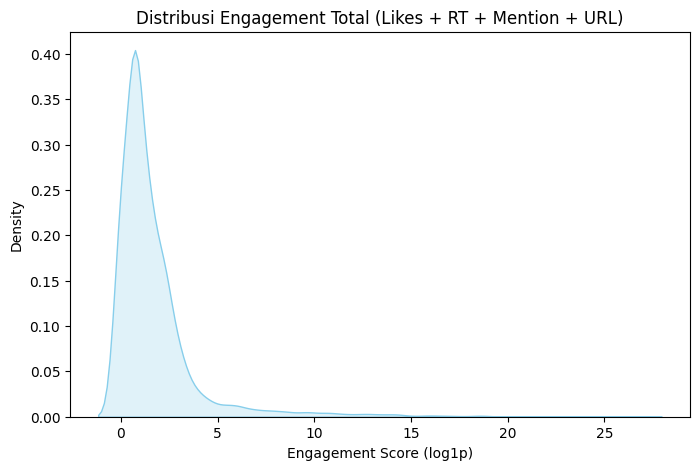

In [ ]:
# === Visualisasi awal distribusi engagement ===
import matplotlib.pyplot as plt, seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(df_out["engagement_total"], fill=True, color="skyblue")
plt.title("Distribusi Engagement Total (Likes + RT + Mention + URL)")
plt.xlabel("Engagement Score (log1p)")
plt.ylabel("Density")
plt.show()


In [ ]:
# === 10.1 Latent Dirichlet Allocation (LDA) ===
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 1️⃣ Vektorisasi
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=5,
    stop_words='english'  # ganti 'indonesian' kalau mau untuk IndoBERT-style
)
X = vectorizer.fit_transform(df["text_clean"])
feature_names = vectorizer.get_feature_names_out()

# 2️⃣ Training LDA
lda_model = LatentDirichletAllocation(
    n_components=5,  # ubah sesuai jumlah topik
    random_state=42,
    learning_method='batch'
)
lda_model.fit(X)

print("Model LDA sudah terbentuk ✅")


Model LDA sudah terbentuk ✅


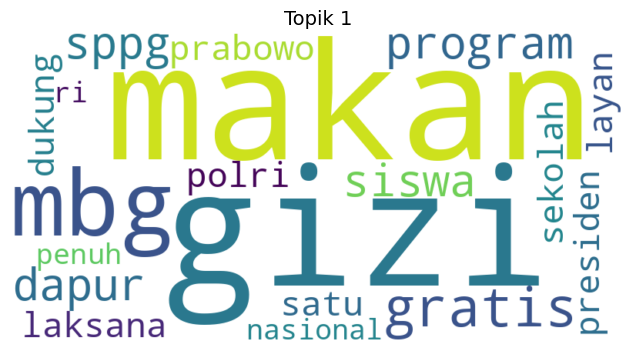

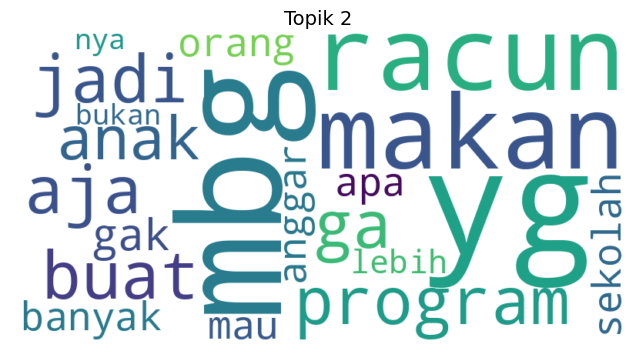

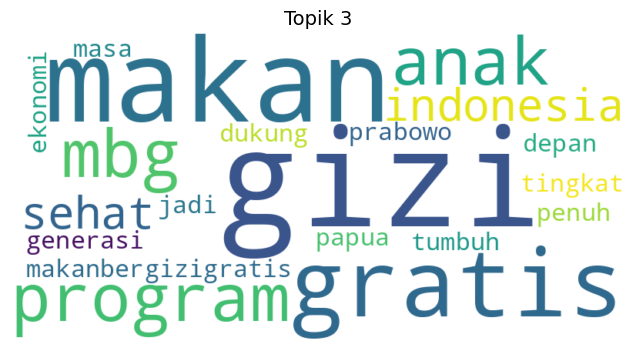

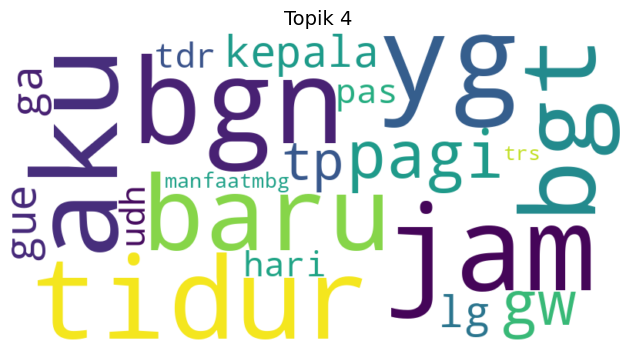

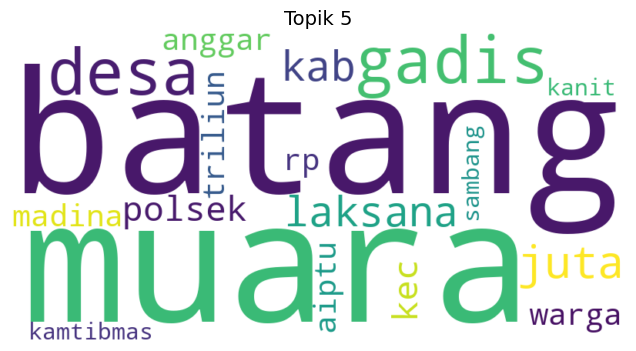

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, topic in enumerate(lda_model.components_):
    words = [feature_names[j] for j in topic.argsort()[:-21:-1]]
    cloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))
    plt.figure(figsize=(8, 4))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topik {i+1}", fontsize=14)
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

# === Buat dataframe hasil inferensi topik ===
# Probabilitas distribusi topik untuk setiap dokumen
topic_distribution = lda_model.transform(X)

# Tentukan topik dominan untuk tiap dokumen
dominant_topic = np.argmax(topic_distribution, axis=1)

# Buat DataFrame hasil
df_topics = pd.DataFrame({
    "text_clean": df["text_clean"].values,
    "dominant_topic": dominant_topic,
    "engagement_total": df["engagement_total"].values  # pastikan kolom ini ada di df
})

print("✅ DataFrame df_topics berhasil dibuat!")
df_topics.head()


✅ DataFrame df_topics berhasil dibuat!


,text_clean,dominant_topic,engagement_total
0,mbg umkm sebar suara anak anak dapat manfaat u...,2,1.386294
1,hadir umkm buat mbg jadi solusi efektif buat s...,2,1.386294
2,mbg umkm bantu masyarakat dapat akses pangan k...,2,1.386294
3,umkm keroyokan banget mbg masyarakat lebih seh...,2,1.386294
4,salut buat maju mbg berkat libat penuh umkm tu...,2,1.386294


/tmp/ipython-input-2315437189.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_engagement, x="dominant_topic", y="engagement_total", palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


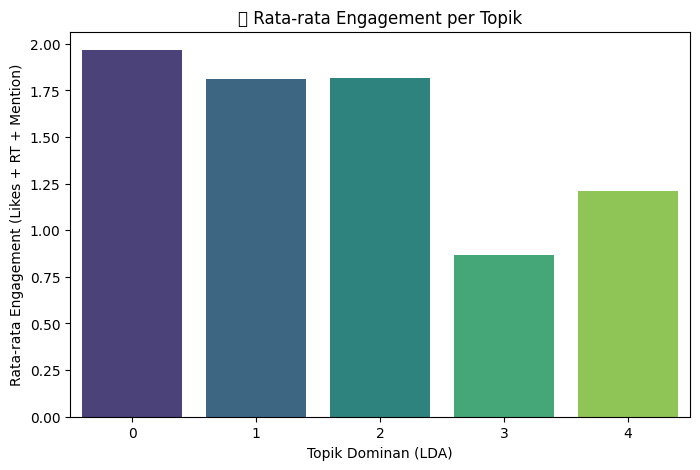

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rata-rata engagement per topik
topic_engagement = df_topics.groupby("dominant_topic")["engagement_total"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=topic_engagement, x="dominant_topic", y="engagement_total", palette="viridis")
plt.title("📊 Rata-rata Engagement per Topik")
plt.xlabel("Topik Dominan (LDA)")
plt.ylabel("Rata-rata Engagement (Likes + RT + Mention)")
plt.show()


In [ ]:
import numpy as np
topic_distribution = lda_model.transform(X)
print("Distribusi probabilitas topik (per dokumen):")
print(topic_distribution[:10])


Distribusi probabilitas topik (per dokumen):
[[0.22498952 0.02042036 0.71437379 0.0202063  0.02001003]
 [0.0183511  0.28432449 0.66085389 0.01827354 0.01819698]
 [0.0155851  0.01554436 0.93801256 0.01545953 0.01539845]
 [0.02242866 0.02272068 0.9099519  0.02227758 0.02262118]
 [0.01722751 0.16023755 0.78910701 0.01675808 0.01666985]
 [0.01842271 0.34896691 0.59603414 0.01833053 0.01824572]
 [0.02241186 0.02270801 0.9101704  0.02246435 0.02224539]
 [0.02021108 0.1993604  0.6189457  0.14146213 0.0200207 ]
 [0.01696059 0.01687886 0.93279964 0.0166802  0.0166807 ]
 [0.01688245 0.01734372 0.93171768 0.01738744 0.01666871]]


In [ ]:
import numpy as np, pandas as pd

# Probabilitas per dokumen
topic_distribution = lda_model.transform(X)

# Topik dominan & skor dominannya
dominant_topic = topic_distribution.argmax(axis=1)
dominant_score = topic_distribution.max(axis=1)

df_topics = pd.DataFrame({
    "text_clean": df["text_clean"].values,
    "dominant_topic": dominant_topic,
    "dominant_score": dominant_score,
    "engagement_total": df["engagement_total"].values
})

# Diagnostik sebaran topik
print(df_topics["dominant_topic"].value_counts().sort_index())
df_topics.head()


dominant_topic
0    1792
1    3413
2    2831
3     969
4     212
Name: count, dtype: int64


,text_clean,dominant_topic,dominant_score,engagement_total
0,mbg umkm sebar suara anak anak dapat manfaat u...,2,0.714374,1.386294
1,hadir umkm buat mbg jadi solusi efektif buat s...,2,0.660854,1.386294
2,mbg umkm bantu masyarakat dapat akses pangan k...,2,0.938013,1.386294
3,umkm keroyokan banget mbg masyarakat lebih seh...,2,0.909952,1.386294
4,salut buat maju mbg berkat libat penuh umkm tu...,2,0.789107,1.386294


In [ ]:
feature_names = vectorizer.get_feature_names_out()

def top_words_per_topic(lda, feat_names, n=10):
    labels = []
    for k, topic in enumerate(lda.components_):
        words = [feat_names[i] for i in topic.argsort()[:-n-1:-1]]
        labels.append((k, ", ".join(words)))
    return labels

topic_labels = dict(top_words_per_topic(lda_model, feature_names, n=8))
df_topics["topic_label"] = df_topics["dominant_topic"].map(topic_labels)
topic_labels


{0: 'gizi, makan, mbg, gratis, program, sppg, dapur, siswa',
 1: 'mbg, yg, racun, makan, program, jadi, buat, ga',
 2: 'gizi, makan, gratis, program, anak, mbg, indonesia, sehat',
 3: 'bgn, jam, aku, yg, tidur, baru, bgt, pagi',
 4: '2025, batang, muara, gadis, desa, juta, laksana, kab'}

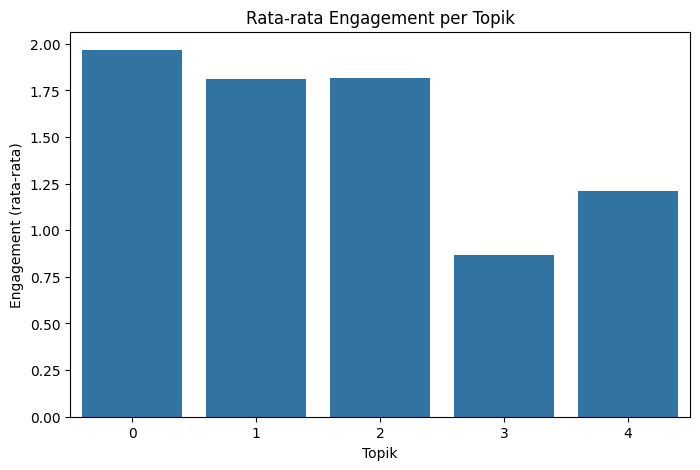

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns

topic_eng = df_topics.groupby("dominant_topic")["engagement_total"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=topic_eng, x="dominant_topic", y="engagement_total")
plt.title("Rata-rata Engagement per Topik")
plt.xlabel("Topik")
plt.ylabel("Engagement (rata-rata)")
plt.show()
